## Отрицательное биномиальное распределение, $\mathrm{NB}(r, p)$

---

In [1]:
import importlib
import numpy as np
import pandas as pd
import seaborn as sns
from utils import utils, nb_utils
from matplotlib import pyplot as plt


def reload_files():
    importlib.reload(nb_utils)
    importlib.reload(utils)

In [2]:
DATASETS = {
    0: 'acl-imdb'
}

LABELS = {
    'positive': 1,
    'negative': -1
}

In [3]:
reload_files()

### Загружаем экспериментальные данные

---

In [4]:
data = utils.load_data(DATASETS[0])

data.head()

,text,label
0,Don't bother trying to watch this terrible min...,-1
1,"Space Camp, which had the unfortunate luck to ...",-1
2,"Well, I suppose the good news concerning Willi...",-1
3,"After leaving TV's popular ""The Andy Griffith ...",-1
4,"I knew I was going to see a low budget movie, ...",-1


### Токенизируем данные

---

In [4]:
data['tokens'] = [[token for token in utils.word_tokenize(text, stop_words=False)] for text in data['text']]

data.head()

,text,label,tokens
0,Don't bother trying to watch this terrible min...,-1,"[do, not, bother, trying, to, watch, this, ter..."
1,"Space Camp, which had the unfortunate luck to ...",-1,"[space, camp, which, had, the, unfortunate, lu..."
2,"Well, I suppose the good news concerning Willi...",-1,"[well, i, suppose, the, good, news, concerning..."
3,"After leaving TV's popular ""The Andy Griffith ...",-1,"[after, leaving, tv, s, popular, the, andy, gr..."
4,"I knew I was going to see a low budget movie, ...",-1,"[i, knew, i, was, going, to, see, a, low, budg..."


### Находим части речи

---

In [5]:
from nltk import pos_tag_sents


data['pos_tokens'] = pos_tag_sents(data['tokens'], tagset='universal')
data['pos_tokens'] = utils.pos_filter(data['pos_tokens'])

data.head()

,text,label,tokens,pos_tokens
0,Don't bother trying to watch this terrible min...,-1,"[do, not, bother, trying, to, watch, this, ter...","[(do, VERB), (not, ADV), (bother, VERB), (tryi..."
1,"Space Camp, which had the unfortunate luck to ...",-1,"[space, camp, which, had, the, unfortunate, lu...","[(space, NOUN), (camp, NOUN), (which, DET), (h..."
2,"Well, I suppose the good news concerning Willi...",-1,"[well, i, suppose, the, good, news, concerning...","[(well, ADV), (i, NOUN), (suppose, VERB), (the..."
3,"After leaving TV's popular ""The Andy Griffith ...",-1,"[after, leaving, tv, s, popular, the, andy, gr...","[(after, ADP), (leaving, VERB), (tv, NOUN), (s..."
4,"I knew I was going to see a low budget movie, ...",-1,"[i, knew, i, was, going, to, see, a, low, budg...","[(i, NOUN), (knew, VERB), (i, NOUN), (was, VER..."


### Формируем $n$-граммы

---

In [6]:
data['ngrams'] = utils.ngrams_sents(data['pos_tokens'], n=1)

data.head()

,text,label,tokens,pos_tokens,ngrams
0,Don't bother trying to watch this terrible min...,-1,"[do, not, bother, trying, to, watch, this, ter...","[(do, VERB), (not, ADV), (bother, VERB), (tryi...","[((do, VERB),), ((not, ADV),), ((bother, VERB)..."
1,"Space Camp, which had the unfortunate luck to ...",-1,"[space, camp, which, had, the, unfortunate, lu...","[(space, NOUN), (camp, NOUN), (which, DET), (h...","[((space, NOUN),), ((camp, NOUN),), ((which, D..."
2,"Well, I suppose the good news concerning Willi...",-1,"[well, i, suppose, the, good, news, concerning...","[(well, ADV), (i, NOUN), (suppose, VERB), (the...","[((well, ADV),), ((i, NOUN),), ((suppose, VERB..."
3,"After leaving TV's popular ""The Andy Griffith ...",-1,"[after, leaving, tv, s, popular, the, andy, gr...","[(after, ADP), (leaving, VERB), (tv, NOUN), (s...","[((after, ADP),), ((leaving, VERB),), ((tv, NO..."
4,"I knew I was going to see a low budget movie, ...",-1,"[i, knew, i, was, going, to, see, a, low, budg...","[(i, NOUN), (knew, VERB), (i, NOUN), (was, VER...","[((i, NOUN),), ((knew, VERB),), ((i, NOUN),), ..."


### Оцениваем параметры распределений и проверяем гипотезы согласия

---

In [7]:
import itertools


def nb(data, chunks):
    populations = dict()
    nb_populations = dict()
    for i, (label, label_index) in enumerate(LABELS.items()):
        label_data = data[data['label'] == label_index]
        chapters = utils.chunks(list(itertools.chain.from_iterable(label_data['ngrams'])), chunks[i])
        populations[label] = {k: v for k, v in nb_utils.populate(chapters).items() if sum(v) > 30}
        nb_populations[label] = nb_utils.nb_filter(populations[label])
    return populations, nb_populations

In [8]:
populations, nb_populations = nb(data, chunks=[300, 294])

### Находим нейтральные и полярные $n$-граммы

---

In [9]:
# Нейтральные n-граммы

neutral_keys = nb_populations['positive'].keys() & nb_populations['negative'].keys()

neutral_ngrams = {label: {key: label_population[key] for key in neutral_keys} for label, label_population in nb_populations.items()}

print(f'[neutral ngrams] Total: {len(neutral_keys)}')

[neutral ngrams] Total: 839


In [10]:
# Позитивные n-граммы

positive_keys = nb_populations['positive'].keys() - nb_populations['negative'].keys()

positive_ngrams = {key: nb_populations['positive'][key] for key in positive_keys}

print(f'[positive ngrams] Total: {len(positive_keys)}')

[positive ngrams] Total: 365


In [11]:
# Негативные n-граммы

negative_keys = nb_populations['negative'].keys() - nb_populations['positive'].keys()

negative_ngrams = {key: nb_populations['negative'][key] for key in negative_keys}

print(f'[negative ngrams] Total: {len(negative_keys)}')

[negative ngrams] Total: 273


In [12]:
polar_ngrams = {'positive': positive_ngrams, 'negative': negative_ngrams}

print(f'[polar ngrams] Total: {len(positive_keys) + len(negative_keys)}')

[polar ngrams] Total: 638


---

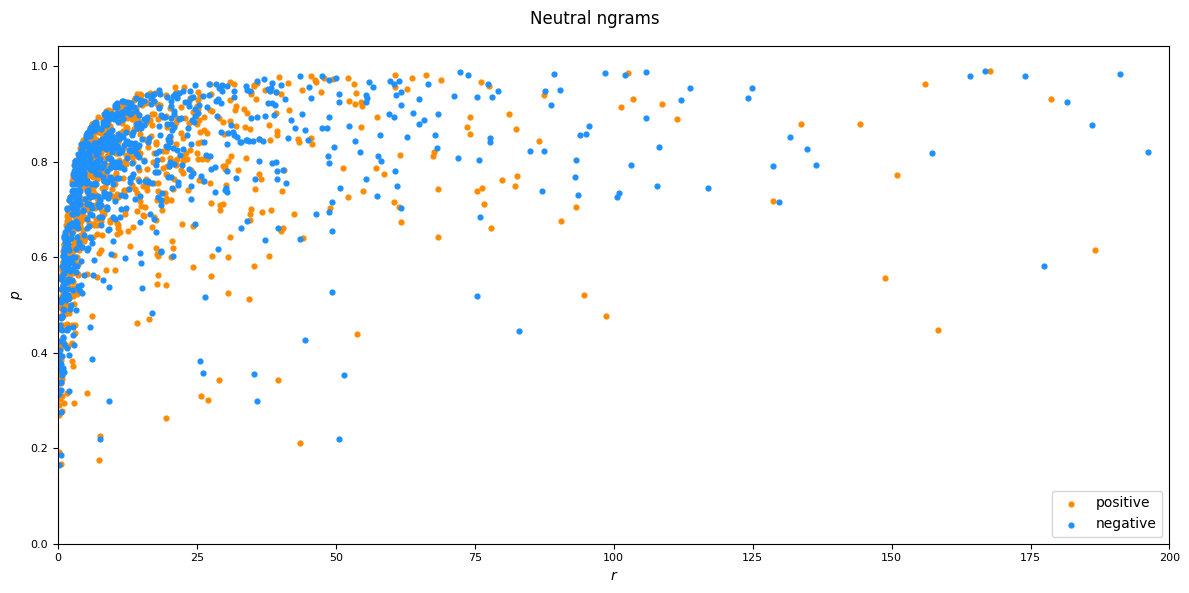

In [13]:
nb_utils.scatter(neutral_ngrams, title='Neutral ngrams', xlabel=r'$r$', ylabel=r'$p$', annotate=False, x_right=200)

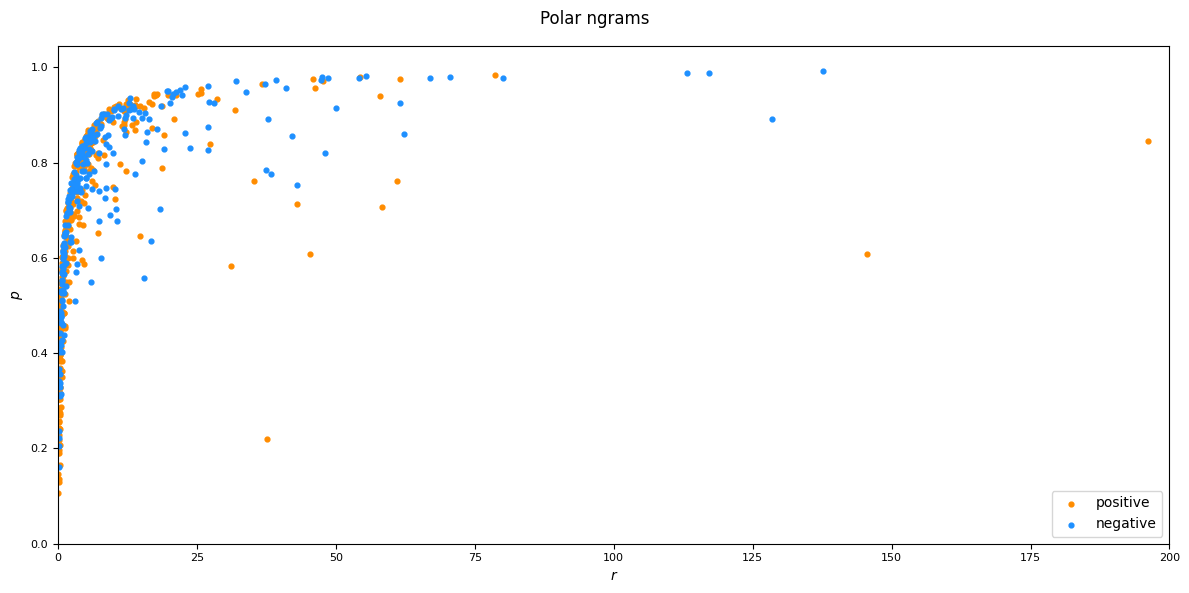

In [14]:
nb_utils.scatter(polar_ngrams, title='Polar ngrams', xlabel=r'$r$', ylabel=r'$p$', annotate=False, x_right=200)

---

In [15]:
def to_dataframe(ngrams):
    df = pd.concat([
        pd.DataFrame(ngrams['positive'], index=['r_pos', 'p_pos']),
        pd.DataFrame(ngrams['negative'], index=['r_neg', 'p_neg'])
    ]).T
    words, tags = zip(*[zip(*ngram) for ngram in df.index])
    df.index = words
    df.insert(0, 'part_of_speech', tags)
    return df[-df.iloc[:,1:].gt(200).any(axis=1)]

### Рассматриваем распределения параметров нейтральных $n$-грамм

---

In [16]:
neutral_df = to_dataframe(neutral_ngrams)

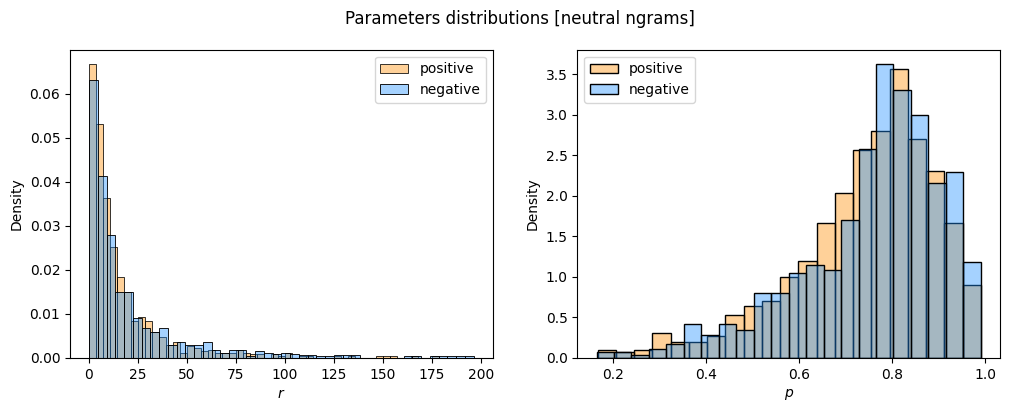

In [17]:
nb_utils.hist(neutral_df, title='Parameters distributions [neutral ngrams]')

In [18]:
from scipy.stats import mannwhitneyu

print(f"r: (mannwhitneyu) pvalue={mannwhitneyu(neutral_df['r_pos'], neutral_df['r_neg']).pvalue}")
print(f"p: (mannwhitneyu) pvalue={mannwhitneyu(neutral_df['p_pos'], neutral_df['p_neg']).pvalue}")

r: (mannwhitneyu) pvalue=0.08944725034964136
p: (mannwhitneyu) pvalue=0.01623062058505556


In [19]:
from scipy.stats import ttest_ind

print(f"r: (ttest) pvalue={ttest_ind(neutral_df['r_pos'], neutral_df['r_neg']).pvalue}")
print(f"p: (ttest) pvalue={ttest_ind(neutral_df['p_pos'], neutral_df['p_neg']).pvalue}")

r: (ttest) pvalue=0.002432208646626682
p: (ttest) pvalue=0.042967301526114235


---

### Рассматриваем разность параметров $r, p$ по отдельным частям речи

In [20]:
neutral_counts = neutral_df['part_of_speech'].value_counts()
neutral_keys = neutral_counts.index[neutral_counts > 10]

list(enumerate(zip(neutral_keys, neutral_counts)))

[(0, (('NOUN',), 317)),
 (1, (('VERB',), 190)),
 (2, (('ADJ',), 119)),
 (3, (('ADV',), 66)),
 (4, (('ADP',), 28)),
 (5, (('PRON',), 19)),
 (6, (('DET',), 11))]

In [21]:
KEY = 2

df = neutral_df[neutral_df['part_of_speech'] == neutral_keys[KEY]]

In [22]:
x, y = df['r_pos'] - df['r_neg'], df['p_pos'] - df['p_neg']

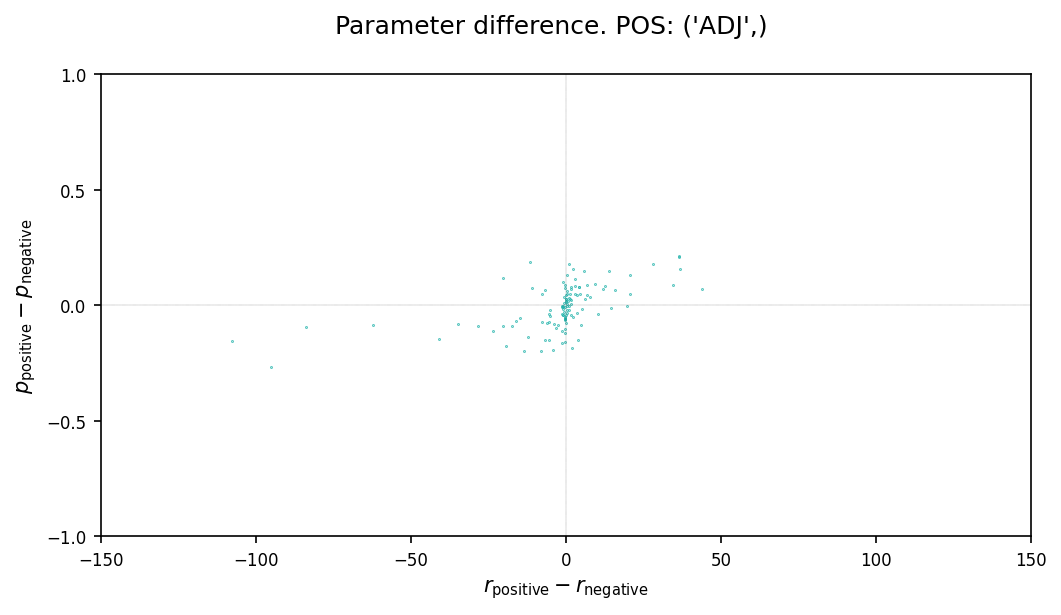

In [23]:
fig, ax = plt.subplots(figsize=(8, 4), dpi=150)

ax.scatter(x, y, s=0.1, marker='o', color='lightseagreen')

ax.axhline(y=0, linewidth=0.1, linestyle='--', color='black')
ax.axvline(x=0, linewidth=0.1, linestyle='--', color='black')

ax.set_xlabel(r'$r_{\mathrm{positive}}-r_{\mathrm{negative}}$')
ax.set_ylabel(r'$p_{\mathrm{positive}}-p_{\mathrm{negative}}$')

ax.set_xlim([-150, 150])
ax.set_ylim([-1, 1])
ax.set_xticks([-150, -100, -50, 0, 50, 100, 150])
ax.set_yticks([-1, -0.5, 0, 0.5, 1])

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

fig.suptitle(f'Parameter difference. POS: {neutral_keys[KEY]}')

plt.show()

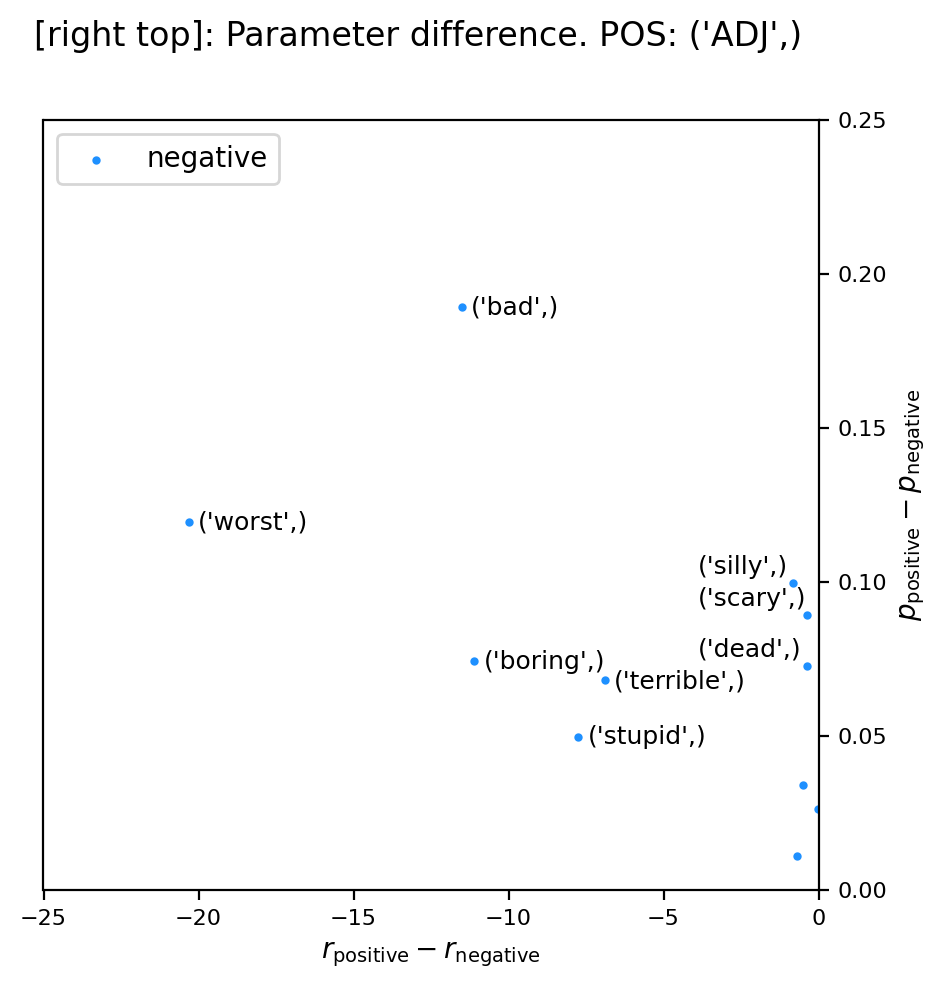

In [24]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=200)

ax.scatter(x[x < 0], y[x < 0], s=4, color='dodgerblue', label='negative')
for i, word in enumerate(df.index):
    if x[i] < -5 and y[i] > 0.045:
        ax.annotate(word, (x[i], y[i]), fontsize=9, xytext=[x[i]+0.3, y[i]-0.0025])
    if x[i] > -5 and x[i] < 0 and y[i] > 0.045:
        ax.annotate(word, (x[i], y[i]), fontsize=9, xytext=[-3.9, y[i]+0.003])
        
ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')
ax.set_xlabel(r'$r_{\mathrm{positive}}-r_{\mathrm{negative}}$')
ax.set_ylabel(r'$p_{\mathrm{positive}}-p_{\mathrm{negative}}$')

ax.set_xlim([-25, 0])
ax.set_ylim([0, 0.25])
ax.set_xticks([-25, -20, -15, -10, -5, 0])
ax.set_yticks([0, 0.05,  0.1, 0.15, 0.2, 0.25])

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.legend(loc='upper left')

fig.suptitle(f'[right top]: Parameter difference. POS: {neutral_keys[KEY]}')

plt.show()

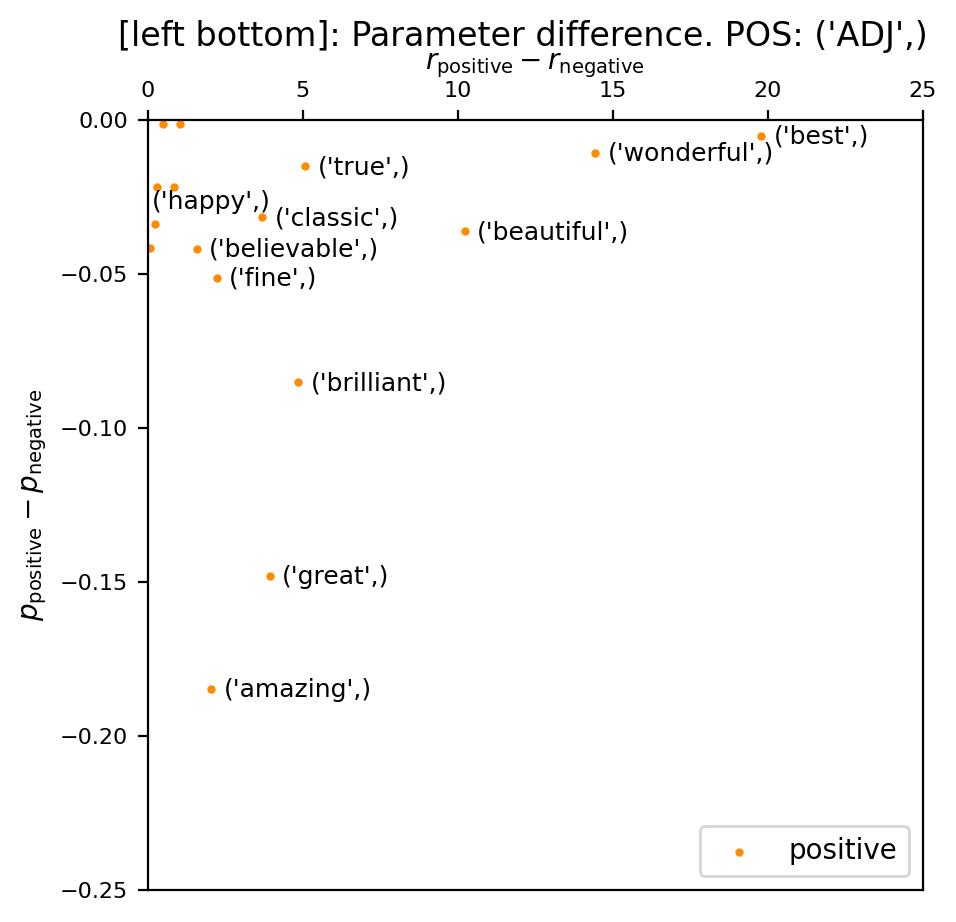

In [25]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=200)

ax.scatter(x[x > 0], y[x > 0], s=4, color='darkorange', label='positive')
for i, word in enumerate(df.index):
    if x[i] > 1 and y[i] < -0.005:
        ax.annotate(word, (x[i], y[i]), fontsize=9, xytext=[x[i]+0.4, y[i]-0.0025])
    if word == ('happy',):
        ax.annotate(word, (x[i], y[i]), fontsize=9, xytext=[x[i]-0.1, y[i]+0.005])
        
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
ax.set_xlabel(r'$r_{\mathrm{positive}}-r_{\mathrm{negative}}$')
ax.set_ylabel(r'$p_{\mathrm{positive}}-p_{\mathrm{negative}}$')

ax.set_xlim([0, 25])
ax.set_ylim([-0.25, 0])
ax.set_xticks([0, 5, 10, 15, 20, 25])
ax.set_yticks([0, -0.05,  -0.1, -0.15, -0.2, -0.25])

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.legend(loc='lower right')

fig.suptitle(f'[left bottom]: Parameter difference. POS: {neutral_keys[KEY]}')

plt.show()